In [1]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 0.1
factor = 1.0208582
r0=0.256318
rm = 0.005  
voxelr = factor*rm
L = 200*rm
print 'L',L
D = 1
kd= 4.0*math.pi*D*4*rm
ka = k_factor*kd
kac = 6*2**0.5*(2*D)*voxelr*(1./r0 -1)*ka/kd
kr = ka*100
kon = (ka*kd)/(ka+kd)
koff = (kr*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 1000
duration = 1.#-math.log(0.1)/N/kon
dt=duration/20
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,rm)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr
aa = 1
bb = Vr*kr/ka
cc = -Vr*kr*N/ka
Aeq = [(-bb-math.sqrt(bb**2-4*aa*cc))/2/aa,(-bb+math.sqrt(bb**2-4*aa*cc))/2/aa][1]/N
print Aeq

L 1.0
Vr 1.03744444194
0.0251327412287 0.251327412287 0.0228479465716
phi 0.143802128271 phir 0.145026182166
0.274371814813


0.274371814813 0.274372012154


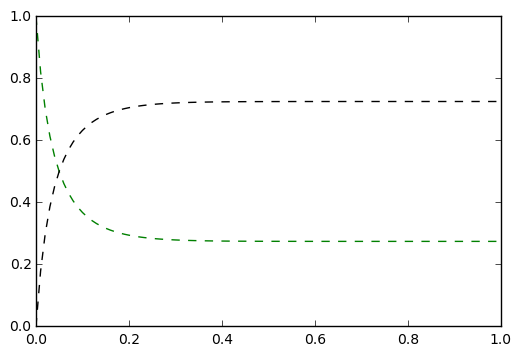

In [2]:
with reaction_rules():#for ODE
    A +B == C | (kon,koff)

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]/N
nco = ode[:,3]/N
plt.plot(to,nao,'g--')
plt.plot(to,nco,'k--')
print Aeq,nao[-1]
#print nco[-1]/nao[-1]**2 , ka/kr

In [3]:
with species_attributes():
    A |B|C | {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B == C | (kac,kr)

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())


In [4]:
def rung(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = gfrd(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n

def rungtest(run):   
    spa = rungfrd(1)
    return spa[:,0]  ,spa[:,1]

def runspa(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = singlerun(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n


In [5]:
run = 1000
#te,nae = rungtest(run)
#print len(te)
ts,nas = runspa(run)


In [6]:
mean = np.mean(nas,axis=0)/N
std = np.std(nas,axis=0)/N

0.27564 0.274371814813 0.462214090014


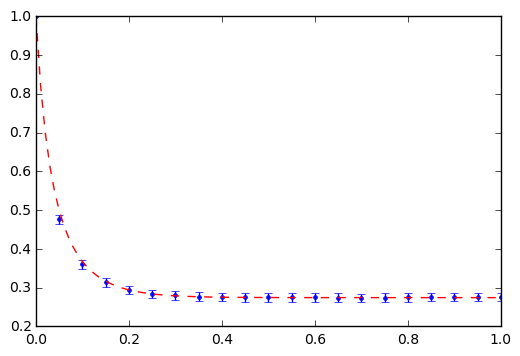

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [9]:
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.plot(to,nao,'r--')
Amean =np.mean(mean[-3:-1] )
print Amean,Aeq,abs(Amean-Aeq)*100/Aeq

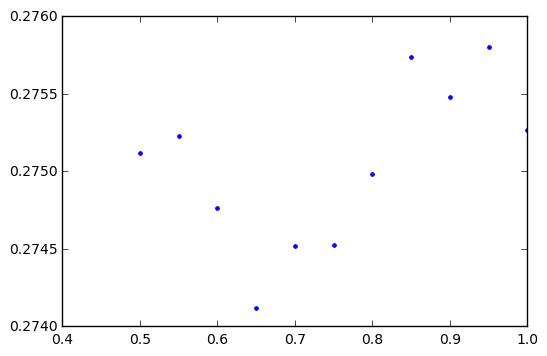

In [8]:
plt.plot(ts[10:],mean[10:],'.')